This notebook uses Pandas and SciPy to explore and perform hypothesis testing on commercial property data scraped from Rightmove.co.uk. The hypothesis which will be tested is that properties east of Greenwich (aka the Prime Meridian) are cheaper on average in terms of price/sq. ft (£/ft2). than properties west of Greenwich.

To begin with, we import the data into a Pandas dataframe, create a column for the £/ft2, and then have a quick look at the initial data.

,prop_id,price,sq_ft,price_per_sq_ft
count,2.500000e+03,2.338000e+03,1503.000000,1456.000000
mean,1.151788e+08,3.575281e+05,4339.467066,218.096567
std,1.828440e+07,2.971682e+05,11936.246311,1269.945014
min,4.728223e+07,1.200000e+05,7.000000,1.935479
25%,1.137929e+08,1.850000e+05,1464.000000,97.037794
50%,1.246948e+08,1.950000e+05,1958.000000,122.554349
75%,1.265663e+08,4.000000e+05,3365.000000,193.514644
max,1.278091e+08,1.500000e+06,304920.000000,42500.000000


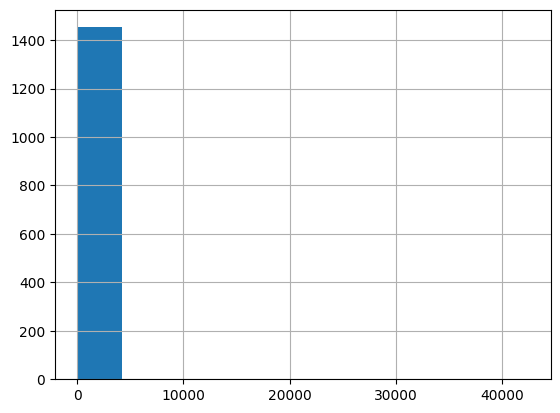

In [4]:
import pandas as pd
import matplotlib as plt
import scipy.stats as stats
import math

df = pd.read_json('scraped_commercial.json')

#Create new price/sq_ft column
price_per_sq_ft = df.price / df.sq_ft
df['price_per_sq_ft'] = price_per_sq_ft

df.price_per_sq_ft.hist()
df.describe()


From the .describe() table we can see that from a total of 2500 properties, we have 1456 which have a p£/ft2 and which will therefore be used for the hypothesis testing. We can also see from the histogram that there must a few outliers. Below, the data is cleaned by dropping the rows missing relevant data, and excluding z scores of >3

In [5]:

#Get rid of entries missing £/sq.ft. and location
cleaned_df = df.dropna(subset=['price_per_sq_ft', 'location'])

# Get rid of z scores of more than 3
for attribute in ['price_per_sq_ft', 'price', 'sq_ft']:
  cleaned_df = cleaned_df[((stats.zscore(cleaned_df[attribute])).abs() < 3)]

Next, we filter the data by creating a mask which returns true for properties with a longitude of > 0(east) and false for properties with a longitude of < 0

In [6]:

# Create two dataframes, one for London properties, one for non-London
def filter_east(x):
  if x[1] > 0:
    return True
  else:
    return False

east_mask = cleaned_df.location.apply(filter_east)

east = cleaned_df[east_mask]
west = cleaned_df[~east_mask]

We can now have a look at the East and West £/ft2 data, and see that the data East of Greenwich is approaching a normal distribution, where the west data is more skewed.

<AxesSubplot: title={'center': 'East'}, ylabel='Frequency'>

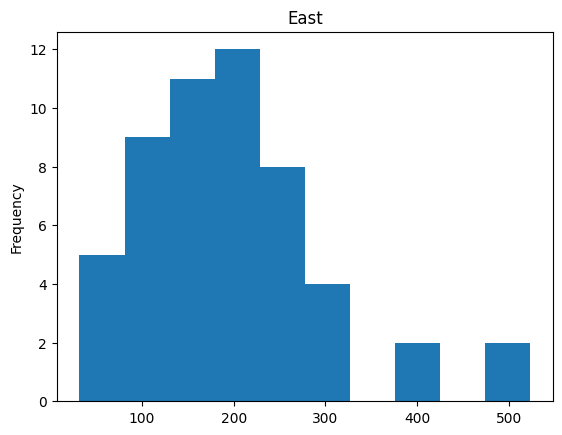

In [7]:
east.price_per_sq_ft.plot(kind='hist', title='East')

count    1351.000000
mean      166.281061
std       138.446543
min        11.037040
25%        97.037794
50%       120.495125
75%       193.514644
max      1033.994334
Name: price_per_sq_ft, dtype: float64

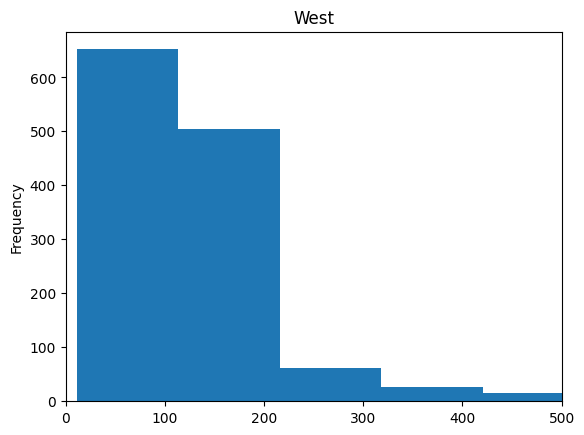

In [24]:
west.price_per_sq_ft.plot(kind='hist', title='West', xlim=(0,500))

We now perform a two sample t-test on the two groups.

In [11]:
stats.ttest_ind(a=east.price_per_sq_ft, b=west.price_per_sq_ft, equal_var=False)

Ttest_indResult(statistic=1.8832251730559253, pvalue=0.06453387178729937)

The p-value of 0.064 tells us that there is a 6.4% chance we would see sample data this far apart if the two groups tested were actually identical, meaning we fail to reject the null hypothesis if using a confidence level of 95%. 

We can further check this by creating a function to produce a confidence interval for the mean at a confidence level of 95% to see if the two intersect, and indeed they do.

In [26]:
def confidence_interval(series):
  mean = series.mean()
  t_critical = stats.t.ppf(q = 0.975, df=series.shape[0]-1)
  std = series.std(ddof=1)

  margin_of_error = t_critical * std / math.sqrt(series.shape[0])

  confidence_interval = (mean - margin_of_error, mean + margin_of_error) 
  return confidence_interval

east_confidence_interval = confidence_interval(east.price_per_sq_ft)
west_confidence_interval = confidence_interval(west.price_per_sq_ft)

print(f'East confidence interval: {east_confidence_interval}')
print(f'West confidence interval: {west_confidence_interval}')


East confidence interval: (165.49650298900104, 221.55927382919526)
West confidence interval: (158.8919521249477, 173.6701701356102)
